In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [1]:
%%capture output
!unzip Model.zip

In [2]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series
from neural_simulations import run_neural_simulations
from activation import decode_spikes_to_activation


--- Iteration 1 ---
STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim


--- Iteration 2 ---
STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
[warning] Coordinate.setValue:  coordinate pelvis_tilt is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_list is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_rotation is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_tx is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_tz is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate lumbar_extension is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate lumbar_bending is locked. Unab

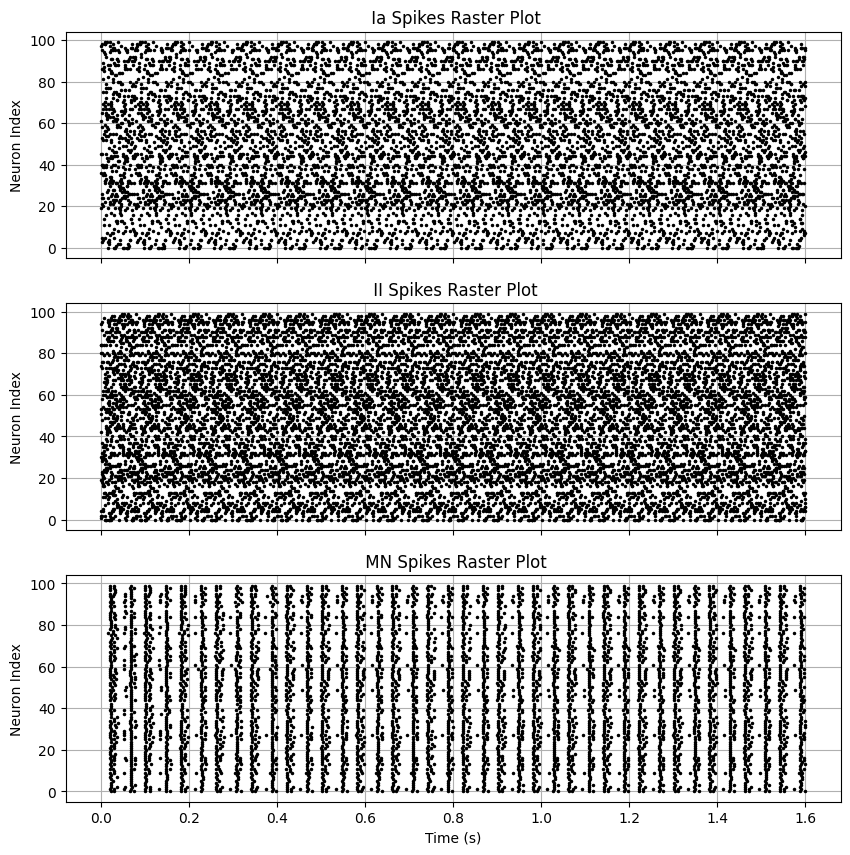

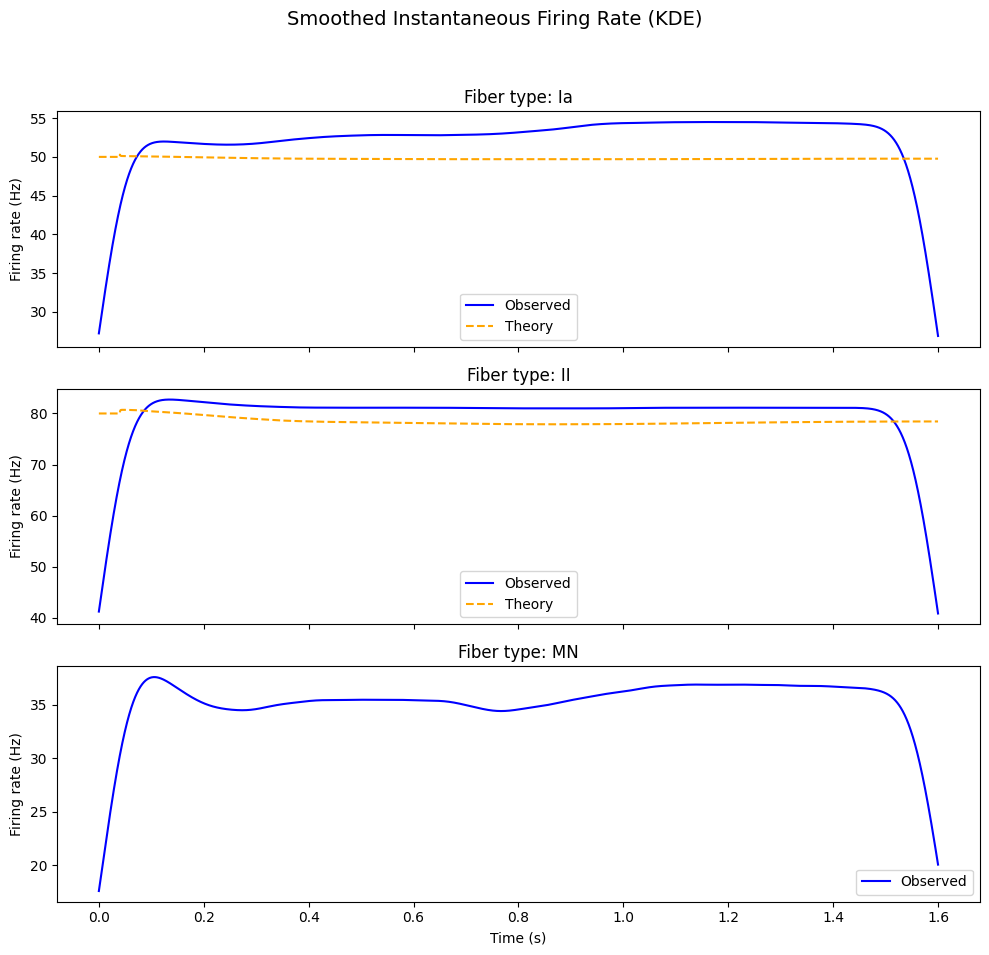

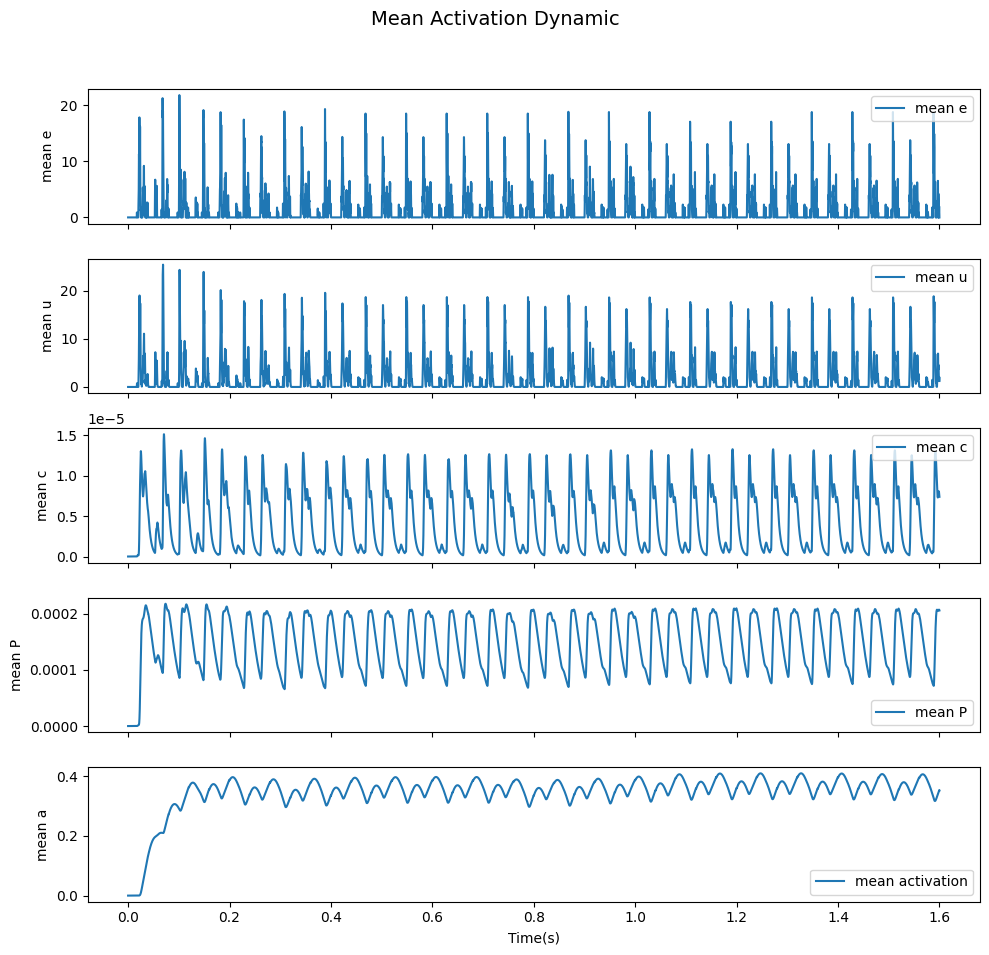

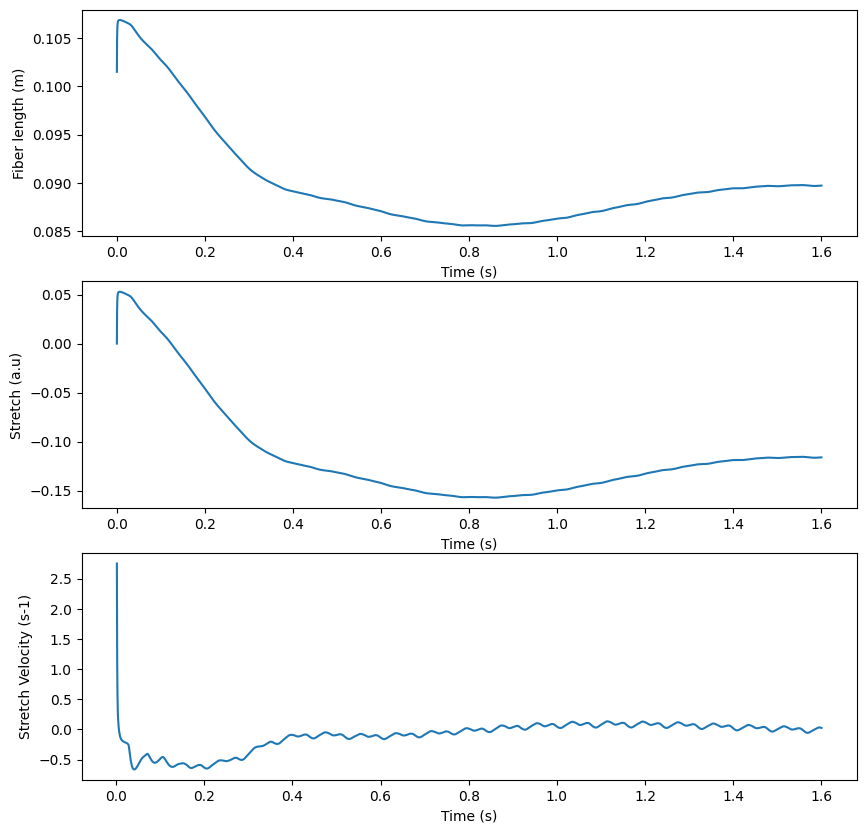

In [9]:
t_reaction = 40*ms
#total_time= 1*second
#n_loop = int(total_time/t_reaction)
n_loop=25
dt = 0.1*ms

p_connection=0.4
weigth=15*uS
neuron_population = {"Ia": 100, "II": 100, "exc": 100, "motor": 100}

initial_values_decoding_spikes={i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0':[0.0], 'a0':[0.0]} for i in range(neuron_population["motor"])}

muscle_name = "iliacus_r"

stretch_initial, velocity_initial = np.zeros(int(t_reaction/dt)), np.zeros(int(t_reaction/dt))
stretch, velocity=stretch_initial, velocity_initial

name_output_spikes = 'spikes.json'
name_output_muscle='df_muscle.csv'
data_muscle = []
data_spikes = {
    "Ia": defaultdict(list),
    "II": defaultdict(list),
    "MN": defaultdict(list)
}
resting_length=None
states_opensim='states.sto'

for j in range(n_loop):

    print(f"--- Iteration {j+1} ---")
    spikes_all=run_neural_simulations(stretch, velocity, neuron_population,dt,t_reaction, w_run=weigth, p_run=p_connection )
    for fiber_name, fiber_spikes in spikes_all.items():
      for neuron_id, spikes in fiber_spikes.items():
        data_spikes[fiber_name][neuron_id].extend(spikes/second+j*t_reaction/second)

    e,u,c,P,activations, final_values=decode_spikes_to_activation([value/second for key, value in spikes_all["MN"].items()], dt/second, t_reaction/second, initial_values_decoding_spikes)
    mean_activation = np.mean(activations, axis=0)
    mean_e=np.mean(e, axis=0)
    mean_u = np.mean(u, axis=0)
    mean_c = np.mean(c, axis=0)
    mean_P = np.mean(P, axis=0)
    initial_values_decoding_spikes =final_values

    # Create temporary files for both input and output
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp, \
        tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_tmp:

        input_path = input_tmp.name
        output_path = output_tmp.name
        np.save(input_path, mean_activation)


        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second),
            '--muscle', muscle_name,
            '--activation', input_path,
            '--ouput_stretch', output_path,
            '--output_all', states_opensim]
        if j>0:
          cmd += ['--initial_state', states_opensim]

        # Run the process in the other environment
        process = subprocess.run(cmd, capture_output=True, text=True)

        if process.stdout.strip():
            print("STDOUT:\n", process.stdout)

        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            fiber_length=np.load(output_path)[1:]
            if j==0:
              resting_length=fiber_length[0]
            stretch=fiber_length/resting_length-1
            velocity=np.gradient(stretch, np.arange(0, t_reaction, dt))

            # Create batch data dictionary
            batch_data_muscle = {
              #**{f'activation_{i}': activations[i] for i in range(neuron_population['motor'])},
              'mean_e': mean_e,
              'mean_u': mean_u,
              'mean_c': mean_c,
              'mean_P': mean_P,
              'mean_activation': mean_activation,
              'fiber_length': fiber_length,
              'stretch': stretch,
              'velocity': velocity
            }
            data_muscle.append(pd.DataFrame(batch_data_muscle))
        else:
          raise RuntimeError(f'Problem in iteration {j}. STDERR: {process.stderr}')

        # Clean up temporary files
        os.unlink(input_path)
        os.unlink(output_path)

df_muscle = pd.concat(data_muscle)
df_muscle['Time']=np.arange(0, len(df_muscle)*dt, dt)
df_muscle.to_csv(name_output_muscle, index=False)

with open(name_output_spikes, "w") as f:
    json.dump(data_spikes, f, indent=4)

plot_times_series(np.arange(0, t_reaction, dt),stretch_initial,name_output_spikes, name_output_muscle)

In [ ]:
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp:

    input_path = input_tmp.name
    np.save(input_path, df['muscle'])


        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second),
            '--muscle', muscle_name,
            '--activation', input_path,
            '--ouput_stretch', output_path,
            '--output_all', states_opensim]
        if j>0:
          cmd += ['--initial_state', states_opensim]

        # Run the process in the other environment
        process = subprocess.run(cmd, capture_output=True, text=True)